## Prerequisite

In [34]:
!pip install biovec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import time
import biovec
#from Bio import SeqIO

In [67]:
import numpy as np 
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
import tensorflow.keras.layers as Layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from keras.layers import Input, Dense, Bidirectional, CuDNNLSTM, Dropout, Embedding, LSTM, GlobalMaxPooling1D, Bidirectional, SpatialDropout1D, Conv1D, Flatten
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Data Preparation

In [37]:
!git clone https://github.com/33220311/Extremophiles
trainFilePath = '/content/Extremophiles/linTrainTrunc.csv'
testFilePath = '/content/Extremophiles/linTest.csv'

fatal: destination path 'Extremophiles' already exists and is not an empty directory.


In [38]:
targets = []
vectors = []

In [39]:
df = pd.read_csv(trainFilePath,names=['sequence','label'],skiprows=1)
df_test = pd.read_csv(testFilePath,names=['seq','label'],skiprows=1)

In [40]:
# Preview data
print('Train Data: ')
print(df.value_counts())
print('Test Data: ')
print(df_test.value_counts())
print(df.head())

Train Data: 
sequence                                                                                                                                                                                                                                                                                                                                                                              label
AAKKTVTKADLVDQVAQATGLKKKDVKAMVDALLAKVEEALANGSKVQLTGFGTFEVRKRKARTGVKPGTKEKIKIPATQYPAFKPGKALKDKVKK                                                                                                                                                                                                                                                                                      1        1
MRHYKTLRYYETVFAVKPTLSEEEMKKKFEQVKEFIKQKGGEILYEEDWGMRQLAYPIQKFNNARYFLVQFKTENPQLPNELDFQLKIDEDVIRWLNFQIKESEVKKNAQ                                                                                                                

In [41]:
sequences = list(df['sequence'])
test_sequences = list(df_test['seq'])

In [42]:
from sklearn.preprocessing import LabelEncoder
# label/integer encoding output variable: (y)
le = LabelEncoder()

y_train_le = le.fit_transform(df['label'])
y_val_le = le.transform(df_test['label'])

In [43]:
#Y_train = y_train_le # (df['label'])
#Y_test = y_val_le #(df_test['label'])

Y_train = np.asarray(y_train_le).astype('float32').reshape((-1,1))
Y_test = np.asarray(y_val_le).astype('float32').reshape((-1,1))

In [44]:
sequences = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences]
test_sequences = [re.sub(r"[UZOB]", "X", seq) for seq in test_sequences]

In [45]:
#counting data
trainLength = len(sequences)
testLength = len(test_sequences)

In [46]:
trainLength

2213

In [47]:
# Combine data to make corpus
frames = [df, df_test]
data = pd.concat(frames)

In [48]:
sequences[0]

'MQKIKLTGLSLIISGLLMAQAQAAEPVYPDQLRLFSLGQGVCGDKYRPVNREEAQSVKSNIVGMMGQWQISGLANGWVIMGPGYNGEIKPGTASNTWCYPTNPVTGEIPTLSALDIPDGDEVDVQWRLVHDSANFIKPTSYLAHYLGYAWVGGNHSQYVGEDMDVTRDGDGWVIRGNNDGGCDGYRCGDKTAIKVSNFAYNLDPDSFKHGDVTQSDRQLVKTVVGWAVNDSDTPQSGYDVTLRYDTATNWSKTNTYGLSEKVTTKNKFKWPLVGETELSIEIAANQSWASQNGGSTTTSLSQSVRPTVPARSKIPVKIELYKADISYPYEFKADVSYDLTLSGFLRWGGNAWYTHPDNRPNWNHTFVIGPYKDKASSIRYQWDKRYIPGEVKWWDWNWTIQQNGLSTMQNNLARVLRPVRAGITGDFSAESQFAGNIEIGAPVPLAADSKVRRARSVDGAGQGLRLEIPLDAQELSGLGFNNVSLSVTPAANQ'

## Make Corpus and Embedding

In [49]:
pv = biovec.models.ProtVec("combinedfile.fas", corpus_fname="corpusfile_path.txt", n=3)

Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 2809/2809 [00:00<00:00, 9455.95it/s]


In [50]:
# The n-gram "QAT" should be trained in advance
pv["QAT"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-0.15370488, -0.14519398,  0.02788352, -0.18664841,  0.09635808,
       -0.22519587, -0.06066583, -0.10532901, -0.16729048,  0.07631644,
       -0.0400929 , -0.06892094, -0.04702073, -0.12632549, -0.07665813,
       -0.20094948,  0.2359131 , -0.2380458 , -0.13702428,  0.17737815,
       -0.2223601 , -0.0531445 , -0.10479046, -0.14511943, -0.13869795,
        0.04934609,  0.00247155,  0.10144829,  0.09997156,  0.17562124,
       -0.05686028, -0.03985419,  0.06772731, -0.22490281, -0.03836979,
       -0.10633717,  0.13887578,  0.13536559, -0.35609865,  0.11371496,
       -0.13741918,  0.13042098,  0.09224077,  0.08069209,  0.09927772,
        0.0962811 ,  0.12888706, -0.12900755, -0.0932648 ,  0.12489805,
       -0.07984818,  0.07615655, -0.04111081,  0.1920929 ,  0.0589103 ,
       -0.0696136 ,  0.05446039,  0.10970257,  0.14285894,  0.17625421,
       -0.08143003,  0.07855506,  0.05675029, -0.01200527, -0.2158084 ,
        0.11390392, -0.05338158, -0.20689772, -0.01967844,  0.03

In [51]:
#pv["XAE"]

In [52]:
# convert whole amino acid sequence into vector
embedding = pv.to_vecs(sequences[0])
embedding

[array([-17.295984  ,  -8.099474  ,  13.203935  , -25.42146   ,
         11.630549  , -15.307919  , -11.061287  ,  -2.7339673 ,
        -18.394558  ,  20.022623  ,  -8.760674  ,   9.819722  ,
          4.8156004 , -23.814802  ,   2.1966429 , -12.588316  ,
         -2.3093657 , -20.537737  ,  -0.8288776 ,   7.1265903 ,
         -2.1942196 , -14.407363  , -20.683939  ,  -4.6508613 ,
         -7.2234983 ,  23.543812  ,   7.211703  ,  13.500005  ,
          0.96801436,  35.822742  , -34.161114  , -24.537214  ,
          8.792674  , -18.235273  ,  -4.533734  ,  -6.687404  ,
         -6.080976  ,  32.494793  , -26.89561   ,  26.341488  ,
        -26.927534  ,  23.256296  ,   8.873469  ,   9.021716  ,
         21.098587  ,  12.786798  ,  21.966654  , -23.73523   ,
        -13.939093  ,  13.859229  , -11.884193  , -24.322826  ,
         -3.2116706 ,  34.577026  ,   9.877475  , -10.787097  ,
         -9.978598  ,  30.986692  ,  14.447629  ,  -5.6457844 ,
          2.9415865 ,  11.163474  ,  -2.

In [53]:
features = [] 
for seq_num in range(len(sequences)):
    embedding = pv.to_vecs(sequences[seq_num])
    features.append(embedding)

In [54]:
test_features = [] 
for seq_num1 in range(len(test_sequences)):
    embedding1 = pv.to_vecs(sequences[seq_num1])
    test_features.append(embedding1)

In [55]:
max_length = 100
features = pad_sequences(features, maxlen=max_length, padding='post', truncating='post')
test_features = pad_sequences(test_features, maxlen=max_length, padding='post', truncating='post')

In [56]:
type(features)

numpy.ndarray

In [57]:
features

array([[[-17,  -8,  13, ..., -13,   0, -12],
        [-15,  -9,  13, ..., -13,   2,  -7],
        [-11,  -6,   9, ..., -14,   3, -11],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[-12,  -9,  10, ..., -14,   1, -12],
        [-12,  -9,  11, ..., -13,   0, -11],
        [-14, -12,  11, ..., -13,   0, -10],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[ -6,  -5,   3, ...,  -6,   0,  -5],
        [ -4,  -4,   4, ...,  -6,   1,  -6],
        [ -7,  -2,   2, ...,  -6,   0,  -5],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[ -5,  -2,   2, ...,  -3,   2,  -5],
        [ -5,  -3,   3, ...,  -4,   1,  -6],
        [ -4,  -2,   2, ...,  -2,   0,  -5

In [58]:
features[3][0].shape

(100,)

In [59]:
test_sequences[3][0].shape

AttributeError: ignored

In [60]:
seq_num

2212

In [61]:
len(features[1])

100

In [62]:
len(test_sequences[1])

690

In [63]:
len(features)

2213

In [64]:
len(test_sequences)

562

In [ ]:
len(Y_train)

In [ ]:
len(Y_test)

## Utility Function

In [68]:
# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [69]:
# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

## Define Model

In [70]:
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

### MLP

In [71]:
 model = Sequential([        
        Dense(trainLength, activation='relu', name='hidden_1', input_dim=100),
        Dropout(0.25),
        Dense(int(trainLength / 2), activation='relu', name='hidden_2'),
        Dropout(0.25),
         Dense(int(trainLength / 2), activation='relu', name='hidden_3'),
        Dropout(0.25),
        Dense(int(trainLength / 2), activation='relu', name='outer'),
        Dropout(0.25),
        #Flatten(),
        Dense(1, activation='sigmoid'),
    ])

In [72]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

In [73]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [74]:
 history = model.fit(
     features, Y_train,
     epochs=50, batch_size=256,
     validation_data=(test_features, Y_test),
     callbacks=[es]
     )

Epoch 1/50
9/9 [==============================] - 107s 12s/step - loss: 0.7036 - accuracy: 0.5135 - val_loss: 0.6936 - val_accuracy: 0.5141
Epoch 2/50
9/9 [==============================] - 104s 12s/step - loss: 0.7012 - accuracy: 0.5143 - val_loss: 0.6963 - val_accuracy: 0.5139
Epoch 3/50
9/9 [==============================] - 104s 12s/step - loss: 0.6989 - accuracy: 0.5152 - val_loss: 0.6983 - val_accuracy: 0.5134
Epoch 4/50
9/9 [==============================] - 116s 13s/step - loss: 0.6968 - accuracy: 0.5164 - val_loss: 0.7002 - val_accuracy: 0.5133
Epoch 4: early stopping


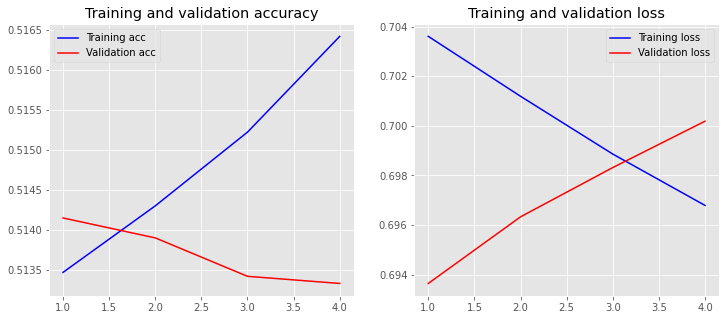

In [75]:
plot_history(history)

In [76]:
display_model_score(model,
     [features, Y_train],
     [test_features, Y_test],
     [test_features, Y_test],
     256)

9/9 [==============================] - 30s 3s/step - loss: 0.6872 - accuracy: 0.5218
Train loss:  0.6872207522392273
Train accuracy:  0.5218075513839722
----------------------------------------------------------------------
3/3 [==============================] - 7s 2s/step - loss: 0.7002 - accuracy: 0.5133
Val loss:  0.700187087059021
Val accuracy:  0.5133273601531982
----------------------------------------------------------------------
3/3 [==============================] - 7s 2s/step - loss: 0.7002 - accuracy: 0.5133
Test loss:  0.700187087059021
Test accuracy:  0.5133273601531982


In [77]:
y_pred = model.predict(test_features)

In [79]:
y_pred = np.reshape(y_pred,(len(y_pred),)).astype(int)

ValueError: ignored

In [80]:
print(classification_report(Y_test, y_pred))

ValueError: ignored

### Bi-LSTM

In [81]:
features.shape

(2213, 100, 100)

In [82]:
x_input = Input(shape=(100,))
emb = Embedding(21, 128, input_length=max_length)(x_input)
bi_rnn = Bidirectional(CuDNNLSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 128)          2688      
                                                                 
 bidirectional (Bidirectiona  (None, 128)              99328     
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 102,145
Trainable params: 102,145
Non-trainable params: 0
_______________________________________________________

In [84]:
Y_train.shape

(2213, 1)

In [85]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [86]:
history = model1.fit(
     features, Y_train,
     epochs=50, batch_size=256,
     validation_data=(test_features, Y_test),
     callbacks=[es]
     )

Epoch 1/50


ValueError: ignored

In [ ]:
# saving model weights.
model1.save_weights('/content/Extremophiles/BLSTM1.h5')

In [ ]:
plot_history(history1)

In [ ]:
display_model_score(model1,
     [features, Y_train],
     [test_features, Y_test],
     [test_features, Y_test],
     256)

In [ ]:
y_pred = model.predict(test_features)

In [ ]:
y_pred = np.reshape(y_pred,(len(y_pred),)).astype(int)

In [ ]:
print(classification_report(Y_test, y_pred))